In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /Users/krishan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/krishan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/krishan/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/krishan/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [9]:
#read in the data
df = pd.read_csv('Reviews.csv')
print(df.shape)
#scale down the data
df = df.iloc[:500,:]
print(df.shape)

(568454, 10)
(500, 10)


In [10]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Quick EDA


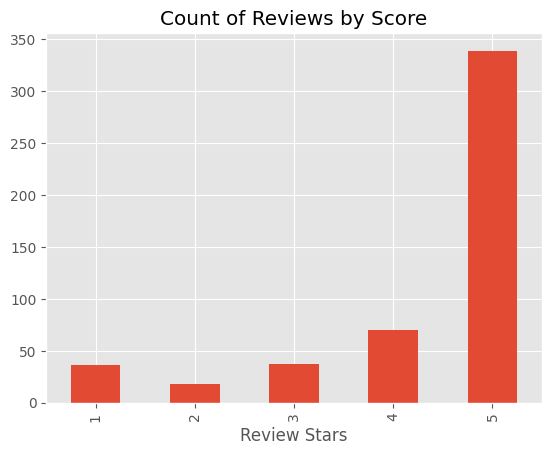

In [14]:
ax=df['Score'].value_counts().sort_index().plot.bar(title='Count of Reviews by Score')

ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [17]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [21]:
tokens=nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [25]:
tagged=nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [32]:
entities= nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1 Vader Sentiment Analysis

We will use NLTK's SentimentIntensityAnalyzer to get the sentiment scores for each of the sentences in the dataset.

- This uses a lexicon of positive and negative words to determine the sentiment score of each sentence.
   1. Stop words are removed
   2. Each word is checked against the lexicon and assigned a polarity score

In [36]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/krishan/nltk_data...


In [39]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [40]:
sia.polarity_scores('This is the worst movie ever made!')

{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'compound': -0.6588}

In [41]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [42]:
# run the polarity scores on the entire dataset
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):

    text=row['Text']
    myid=row['Id']
    res[myid]=sia.polarity_scores(text)
    

  0%|          | 0/500 [00:00<?, ?it/s]

In [49]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left', on='Id')


In [51]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# VADER's Results

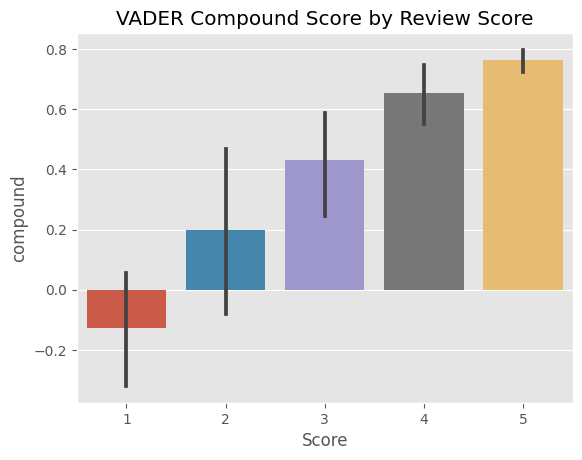

In [54]:
ax= sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('VADER Compound Score by Review Score')
plt.show()

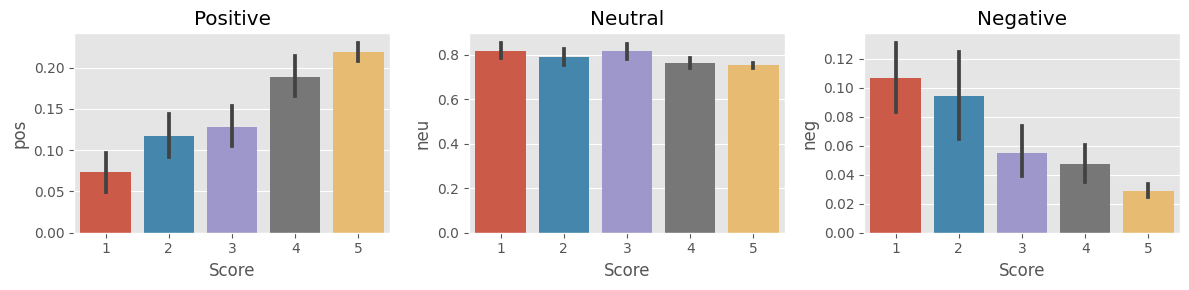

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Step 3 Roberta Pretrained Model

- Use a model trained on large amount of data
- Transformer model accounts for the words but also the context of the other words

In [61]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [62]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [65]:
#Vader results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [71]:
# Run for Roberta model
encoded_text= tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

scores_dict={
    'roberta_negative': scores[0],
    'roberta_neutral': scores[1],
    'roberta_positive': scores[2]
}

scores_dict

{'roberta_negative': 0.97635514,
 'roberta_neutral': 0.020687485,
 'roberta_positive': 0.0029573753}

In [72]:
def polarity_scores_roberta(example):
    encoded_text= tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores

    scores_dict={
        'roberta_negative': scores[0],
        'roberta_neutral': scores[1],
        'roberta_positive': scores[2]
    }

    return scores_dict


In [84]:
# run the polarity scores on the entire dataset
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):

    try:

        text=row['Text']
        myid=row['Id']
        vader_result =sia.polarity_scores(text)
        vader_result_rename={}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"]=value

        roberta_result = polarity_scores_roberta(text)

        both={**vader_result_rename, **roberta_result}
        res[myid]=both
    except RuntimeError:
        print(f'Broke for id {myid}')
        

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [85]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')

In [86]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_negative,roberta_neutral,roberta_positive,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907485,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Compare Scores between Models


In [87]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_negative', 'roberta_neutral', 'roberta_positive', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

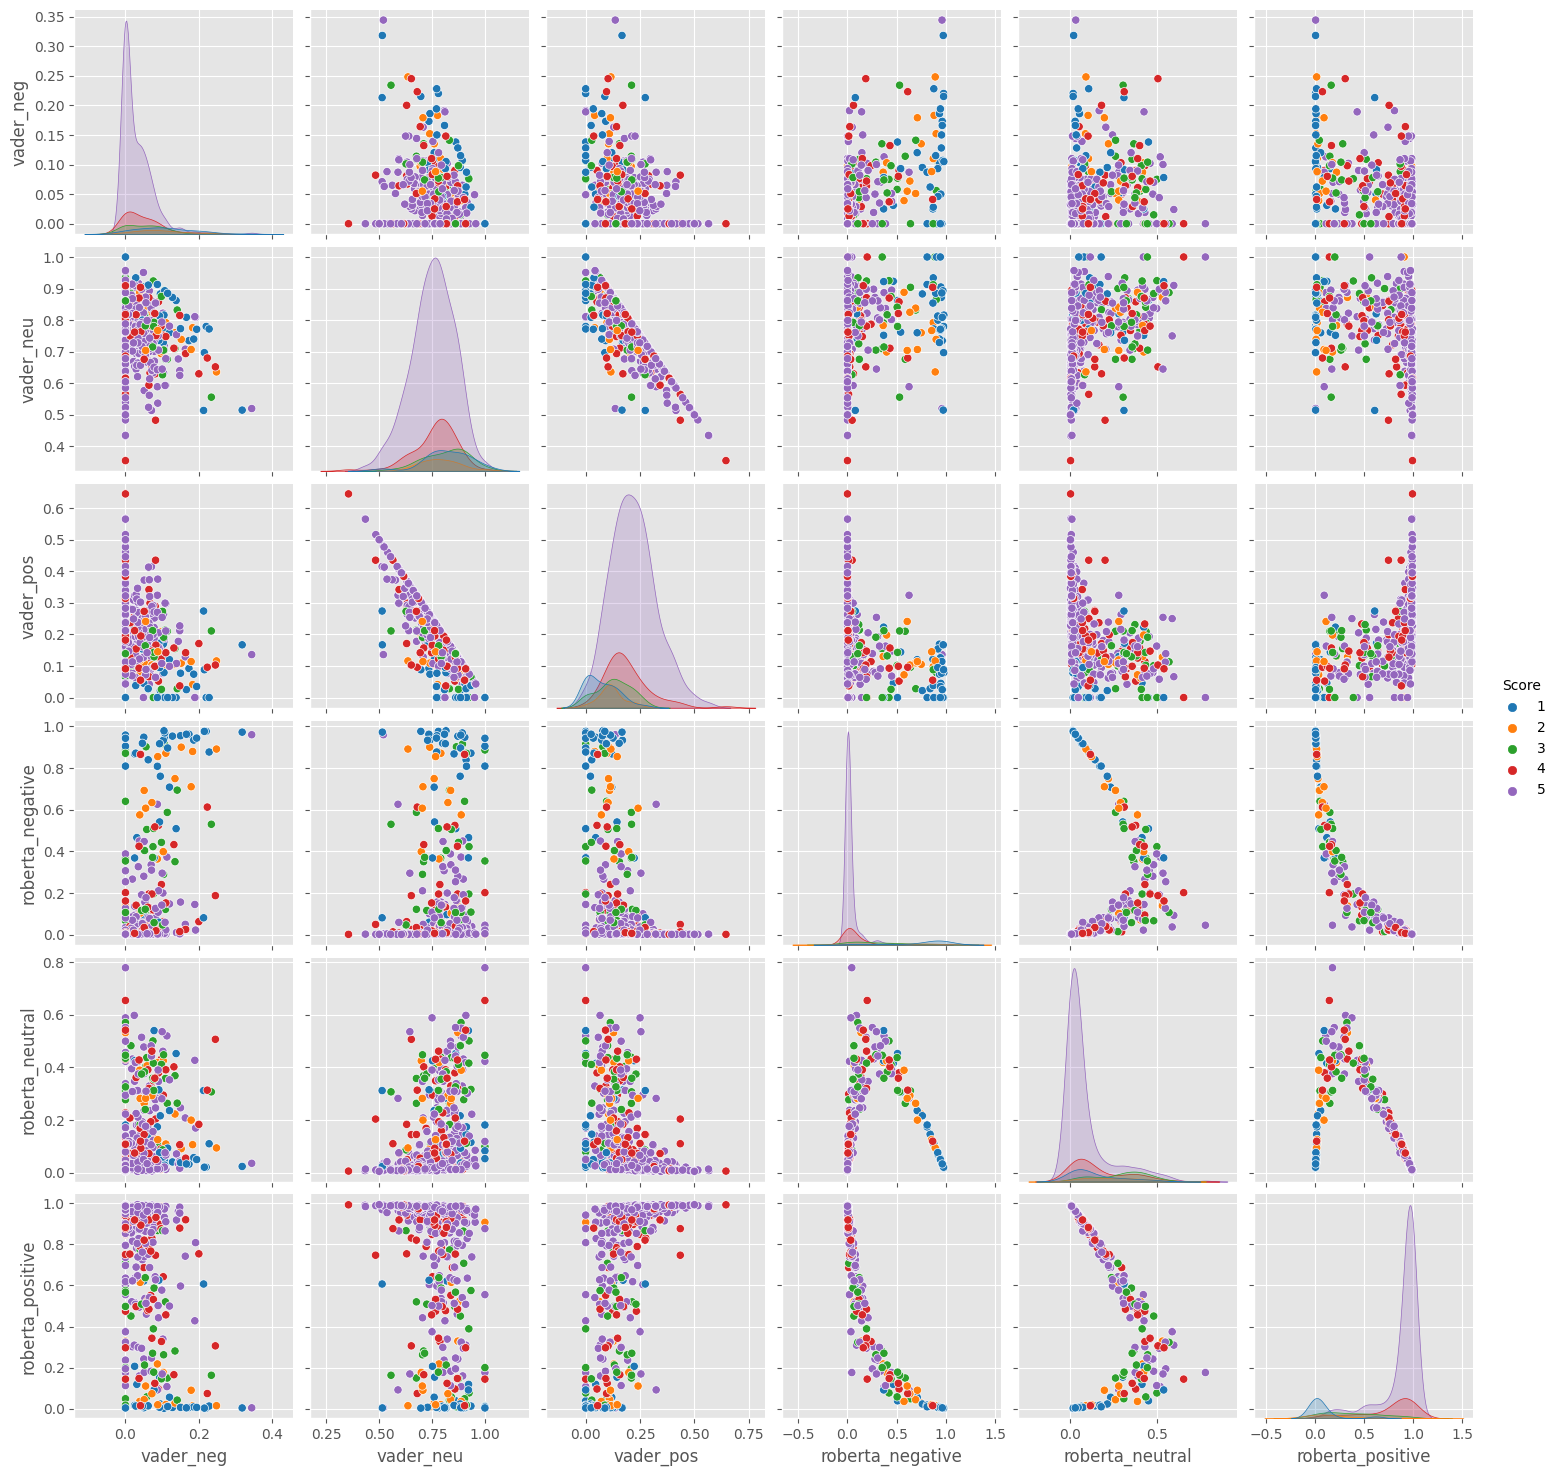

In [91]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_negative', 'roberta_neutral', 'roberta_positive'],
       hue='Score',
       palette='tab10')
plt.show()

## step 4 Review Examples:

- Positive 1-Star and negative 5-Star reviews

Lets look at some examples of the reviews that were misclassified by the model.

In [95]:
results_df.query('Score == 1')\
    .sort_values('roberta_positive', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [96]:
results_df.query('Score == 1')\
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [97]:
#negative sentiment 5 star review

results_df.query('Score == 5')\
    .sort_values('roberta_negative', ascending=False)['Text'].values[0]


'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [98]:
results_df.query('Score == 5')\
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Extra: The Transformer Pipeline

quick and easy way to run sentiment analysis on a text

In [99]:
from transformers import pipeline

sent_pipe = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [100]:
sent_pipe('I love this movie!')

[{'label': 'POSITIVE', 'score': 0.9998775720596313}]